In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd

import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2)

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.display import display

In [2]:
import pymc3 as pm
import theano
import theano.tensor as T
from scipy.stats.stats import pearsonr

In [3]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [4]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

To recap, variables of interest include: 

+ Echo parameters (LV systolic, RV size, pulmonary hypertension)
+ Fluids (day 1: missing term = 1 only if missing on day 1, day1-2: missing term = 1 if missing on day 1 or 2, day1-3: missing term = 1 if missing on day 1, day 2 or day 3)
+ Interactions: fluids x echo variables, fluids x CHF, echo x CHF
+ Covariates: Age, gender, BMI, BMI missing, mech vent, CHF, MDRD, Cr missing, apache score, lactate, lactate missing, ICU type, pressors indicator variable

Because of collinearity: 

+ Use only 1 fluid term per model
+ Use only 1 echo type variable per model
+ Use forward selection for interaction terms

In [5]:
query = """
SELECT * FROM icu_features
"""
ef = pd.read_sql_query(query, con)
ef.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [6]:
len(ef)

61532

In [7]:
F = (ef['use_record'] == 1)

In [8]:
ef = ef.loc[F]
len(ef)

9320

# Preprocessing

## Add MDRD to table

In [9]:
def mdrd(data):
    creat = data.lab_creatinine
    age = data.age/np.timedelta64('1', 'Y')
    age.loc[age<0] = age.max()
    gender = data.gender.apply(lambda x: 0.742 if x == 'F' else 1)
    ethnicity = data.ethnicity.apply(lambda x: 1.212 if 'AFRICAN AMERICAN' in x else 1)
    return 175*creat**(-1.154) * age**(-0.203) * gender * ethnicity

In [10]:
value = mdrd(ef)
ef['mdrd'] = value
discrete = pd.cut(value, [0, 15, 30, 44, 60, 90, 1000000], labels=[5, 4, 3, 2, 1, 0], include_lowest=True)
ef['mdrd_discrete'] = discrete
discrete.value_counts()

0    2524
1    2068
2    1439
4    1280
3    1258
5     503
dtype: int64

In [11]:
discrete = pd.cut(value, [0, 30, 60, 1000000], labels=[2, 1, 0], include_lowest=True)
ef['mdrd_3'] = discrete
discrete.value_counts()

0    4592
1    2697
2    1783
dtype: int64

## General features table

In [13]:
def normalize(x):
    x = x.copy()
    I = ~np.isnan(x)
    x[I] = (x[I] - x[I].mean())/x[I].std()
    return x

In [14]:
X = pd.DataFrame()

# build the features table
age = ef.age/np.timedelta64('1', 'Y') # time in years
age_masked = age < 0 # if age is less than 0, then the person is above 89 (90?)
age = normalize(age)
age[age_masked] = 0
X['age'] = age
X['age_over_90'] = age_masked.astype(float)

gender = ef.gender
gender = (gender == 'F').astype(float)
X['gender'] = gender

bmi = ef.bmi
bmi_missing = np.isnan(bmi)
bmi = normalize(bmi)
bmi[bmi_missing] = 0
X['bmi'] = bmi
X['bmi_missing'] = bmi_missing.astype(float)

mech_vent = ef.vf_first_day_vent.astype(float)
X['mech_vent'] = mech_vent

chf = ef.ex_congestive_heart_failure.astype(float)
X['CHF'] = chf

mdrd = ef.mdrd
mdrd_missing = np.isnan(mdrd)
mdrd = normalize(mdrd)
mdrd[mdrd_missing] = 0
X['mdrd'] = mdrd

# MDRD missing is already largely covered by BMI missing
# the only other missing values come from missing creatinine lab
# so add that
creatinine_missing = np.isnan(ef.lab_creatinine)
X['creatinine_missing'] = creatinine_missing.astype(float)

apsiii = ef.apsiii
#apsiii_missing = np.isnan(apsiii)
apsiii = normalize(apsiii)
#apsiii[apsiii_missing] = 0
X['apsiii'] = apsiii
#X['apsiii_missing'] = apsiii_missing.astype(float)

no_echo = np.isnan(ef.ea_key)
#X['no_echo'] = no_echo.astype(float)

lvsys = ef.ea_lv_systolic
lv_missing = ((np.isnan(lvsys) | (lvsys < -1)) & ~no_echo).astype(float)
lv_normal = (lvsys == 0).astype(float)
lv_hyperdynamic = (lvsys == -1).astype(float)
lv_mild_depressed = (lvsys == 1).astype(float)
lv_mod_depressed = (lvsys == 2).astype(float)
lv_sev_depressed = (lvsys == 3).astype(float)
X['lv_missing'] = lv_missing
X['lv_normal'] = lv_normal
X['lv_hyper'] = lv_hyperdynamic
X['lv_mild'] = lv_mild_depressed
X['lv_moderate'] = lv_mod_depressed
X['lv_severe'] = lv_sev_depressed

tvpulm = ef.ea_tv_pulm_htn
tv_missing = ((np.isnan(tvpulm) | (tvpulm < -2)) & ~no_echo).astype(float)
tv_normal = (tvpulm == 0).astype(float)
tv_abnormal = ((tvpulm == -2) | (tvpulm > 0)).astype(float)
X['plm_htn_missing'] = tv_missing
X['plm_htn_normal'] = tv_normal
X['plm_htn_abnormal'] = tv_abnormal

rvcavity = ef.ea_rv_cavity
rvcav_missing = ((np.isnan(rvcavity) | (rvcavity < -2)) & ~no_echo).astype(float)
rvcav_normal = (rvcavity == 0).astype(float)
rvcav_small = (rvcavity == -1).astype(float)
rvcav_dilated = ((rvcavity == -2) | (rvcavity > 0)).astype(float)
X['rvcav_missing'] = rvcav_missing
X['rvcav_normal'] = rvcav_normal
X['rvcav_small'] = rvcav_small
X['rvcav_dilated'] = rvcav_dilated

lactate = ef.lab_lactate
lactate_missing = np.isnan(lactate)
lactate = normalize(lactate)
lactate[lactate_missing] = 0
X['lactate'] = lactate
X['lactate_missing'] = lactate_missing.astype(float)

## which ICU was treating the patient
sicu = ef.st_sicu.astype(float)
sicu[np.isnan(sicu)] = 0
nsicu = ef.st_nsicu.astype(float)
nsicu[np.isnan(nsicu)] = 0
micu = ef.st_micu.astype(float)
micu[np.isnan(micu)] = 0
X['sicu'] = sicu
X['nsicu'] = nsicu
X['micu'] = micu

## on vasopressors
on_vaso = ef.filter_vaso.astype(float)
X['on_vaso'] = on_vaso

## fluids
fluid_day1 = ef.fb_day1_balance_ml.values
f1_missing = np.isnan(fluid_day1)
fluid_day1[~f1_missing] = normalize(fluid_day1[~f1_missing])
fluid_day1[f1_missing] = 0
X['fluid_day1'] = fluid_day1
X['fluid_day1_missing'] = f1_missing.astype(float)

fluid_day2 = ef.fb_day2_balance_ml.values
f2_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2)
fluid_day2[~f2_missing] = normalize(fluid_day2[~f2_missing])
fluid_day2[f2_missing] = 0
X['fluid_day2'] = fluid_day2
X['fluid_day2_missing'] = f2_missing.astype(float)

fluid_day3 = ef.fb_day3_balance_ml.values
f3_missing = np.isnan(fluid_day1) | np.isnan(fluid_day2) | np.isnan(fluid_day3)
fluid_day3[~f3_missing] = normalize(fluid_day3[~f3_missing])
fluid_day3[f3_missing] = 0
X['fluid_day3'] = fluid_day3
X['fluid_day3_missing'] = f3_missing.astype(float)

y = (ef.dod - ef.intime) < np.timedelta64(30, 'D')

X.shape, y.shape

((9320, 35), (9320,))

In [15]:
echo_features = {
    'lv': ['lv_missing', 'lv_normal', 'lv_hyper', 'lv_mild', 'lv_moderate', 'lv_severe'], 
    'plm_htn': ['plm_htn_missing', 'plm_htn_normal', 'plm_htn_abnormal'], 
    'rvcav': ['rvcav_missing', 'rvcav_normal', 'rvcav_small', 'rvcav_dilated'], 
}
fluid_features = {
    'fluid_day1': ['fluid_day1', 'fluid_day1_missing'], 
    'fluid_day2': ['fluid_day2', 'fluid_day2_missing'], 
    'fluid_day3': ['fluid_day3', 'fluid_day3_missing'],
}
# Age, gender, BMI, BMI missing, mech vent, CHF, MDRD, Cr missing, apache score, lactate, 
#lactate missing, ICU type, pressors indicator variable
covariates = ['age', 'age_over_90', # age
    "gender", # gender
    "bmi", "bmi_missing", # bmi
    "mech_vent", # mech_vent
    "CHF", # CHF
    "mdrd", "creatinine_missing", # MDRD
    "apsiii", # apache score
    "lactate", "lactate_missing", # lactate
    "sicu", "nsicu", "micu", # icu type
    "on_vaso", # pressors indicator variable
]

Train fluid features x echo features models

In [16]:
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics

In [125]:
ytr, yte = sklearn.model_selection.train_test_split(y, test_size = 0.25, stratify = y)

models = {}
aurocs = {}
scores = {}
cols = {}

Xs = {}

Xc = X[covariates]
X_ = Xc.copy()
Xtr = X_.loc[ytr.index]
Xte = X_.loc[yte.index]

lm = sklearn.linear_model.SGDClassifier(loss = 'log', penalty = 'elasticnet', class_weight = 'balanced')
params = {'l1_ratio': [0.01, 0.05, 0.25, 0.75, 0.95, 0.99], 'alpha': [1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e-5]}
gs = sklearn.model_selection.GridSearchCV(lm, params, cv = 3)

gs.fit(Xtr, ytr)

ypr = gs.predict(Xte)
auroc = sklearn.metrics.roc_auc_score(yte, ypr)
f1 = sklearn.metrics.f1_score(yte, ypr, average = 'weighted')
scores[('null', 'null', 'null')] = (auroc, f1)
print('null', 'null', 'linear', auroc, f1)
print(sklearn.metrics.classification_report(ypr, yte))

def make_data_(fluid_fs, echo_fs): 
    
    Xf = X[fluid_features[fluid_fs]]
    Xe = X[echo_features[echo_fs]]
    Xc = X[covariates]

    return pd.concat([Xf, Xe, Xc], axis = 1)

def make_data(fluid_fs, echo_fs): 
    
    Xf = X[fluid_features[fluid_fs]]
    Xe = X[echo_features[echo_fs]]
    Xc = X[covariates]

    # Interactions: fluids x echo variables, fluids x CHF, echo x CHF
    # Fluids x echo variables
    Xfe = {}
    for cf in Xf.columns: 
        for ce in Xe.columns: 
            Xfe["{}*{}".format(cf, ce)] = Xf[cf]*Xe[ce]
    Xfe = pd.DataFrame(Xfe)

    # Fluids x CHF
    Xfc = {}
    for cf in Xf.columns:
        Xfc["{}*CHF".format(cf)] = Xf[cf] * Xc['CHF']
    Xfc = pd.DataFrame(Xfc)

    # Echo x CHF
    Xec = {}
    for ce in Xe.columns: 
        Xec["{}*CHF".format(ce)] = Xe[ce] * Xc['CHF']
    Xec = pd.DataFrame(Xec)

    return pd.concat([Xf, Xe, Xc, Xfe, Xfc, Xec], axis = 1)

for fluid_fs in ['fluid_day1', 'fluid_day2', 'fluid_day3']: 
    for echo_fs in echo_features.keys(): 
        
        X_ = make_data_(fluid_fs, echo_fs)

        Xtr = X_.loc[ytr.index]
        Xte = X_.loc[yte.index]

        model = sklearn.linear_model.LogisticRegressionCV(penalty = 'l1', solver = 'liblinear')
        model.fit(Xtr, ytr)

        ypr = model.predict(Xte)
        auroc = sklearn.metrics.roc_auc_score(yte, ypr)
        f1 = sklearn.metrics.f1_score(yte, ypr, average = 'weighted')
        scores[(fluid_fs, echo_fs, 'linear')] = (auroc, f1)
        print(fluid_fs, echo_fs, 'linear', auroc, f1)
        print(sklearn.metrics.classification_report(ypr, yte))
        
        models[(fluid_fs, echo_fs)] = model

for fluid_fs in ['fluid_day1', 'fluid_day2', 'fluid_day3']: 
    for echo_fs in echo_features.keys(): 
        
        X_ = make_data(fluid_fs, echo_fs)
        Xs[(fluid_fs, echo_fs)] = X_
        cols[echo_fs] = X_.columns

        Xtr = X_.loc[ytr.index]
        Xte = X_.loc[yte.index]

        model = sklearn.linear_model.LogisticRegressionCV(penalty = 'l1', solver = 'liblinear')
        model.fit(Xtr, ytr)

        ypr = model.predict(Xte)
        auroc = sklearn.metrics.roc_auc_score(yte, ypr)
        f1 = sklearn.metrics.f1_score(yte, ypr, average = 'weighted')
        scores[(fluid_fs, echo_fs, 'interactions')] = (auroc, f1)
        print(fluid_fs, echo_fs, 'interactions', auroc, f1)
        print(sklearn.metrics.classification_report(ypr, yte))
        
        cr = sklearn.metrics.classification_report(yte, ypr)
        
        models[(fluid_fs, echo_fs)] = model
        coefs[(fluid_fs, echo_fs)] = pd.Series(model.coef_[0], index = Xtr.columns)
        
scores = pd.DataFrame(scores).transpose()
scores.columns = ['auroc', 'f1']
scores.groupby(level = 2).describe().loc[(slice(None), ['mean', 'std']),]

null null linear 0.702916714139 0.680025565882
             precision    recall  f1-score   support

      False       0.61      0.88      0.72      1160
       True       0.79      0.44      0.57      1170

avg / total       0.70      0.66      0.65      2330

fluid_day1 plm_htn linear 0.642139683263 0.743197295838
             precision    recall  f1-score   support

      False       0.93      0.79      0.85      1988
       True       0.35      0.67      0.46       342

avg / total       0.85      0.77      0.80      2330

fluid_day1 lv linear 0.64366640082 0.744398371993
             precision    recall  f1-score   support

      False       0.93      0.79      0.85      1986
       True       0.35      0.67      0.46       344

avg / total       0.85      0.77      0.80      2330

fluid_day1 rvcav linear 0.643201549504 0.74415373049
             precision    recall  f1-score   support

      False       0.93      0.79      0.85      1988
       True       0.35      0.68      0.46

auroc        f1
interactions mean  0.646907  0.747540
             std   0.003032  0.002842
linear       mean  0.644923  0.745963
             std   0.002054  0.001780
null         mean  0.702917  0.680026
             std        NaN       NaN

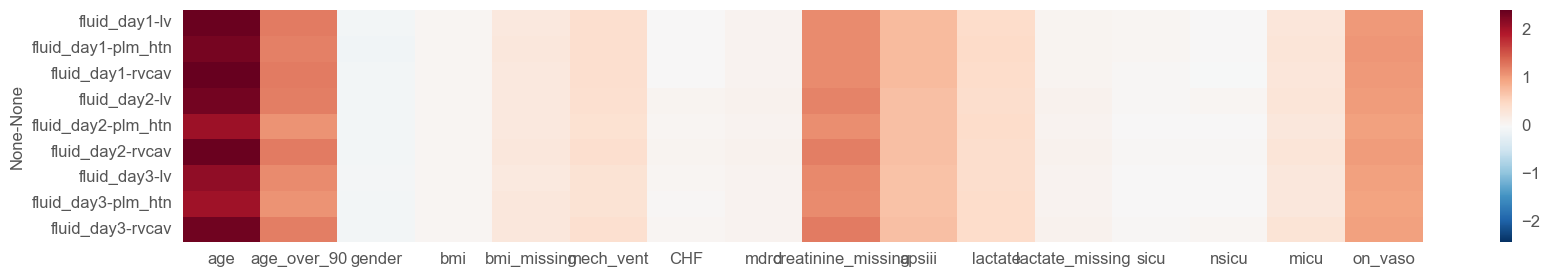

In [121]:
plt.figure(figsize = (20,3))
sns.heatmap(pd.concat(coefs).unstack()[covariates])

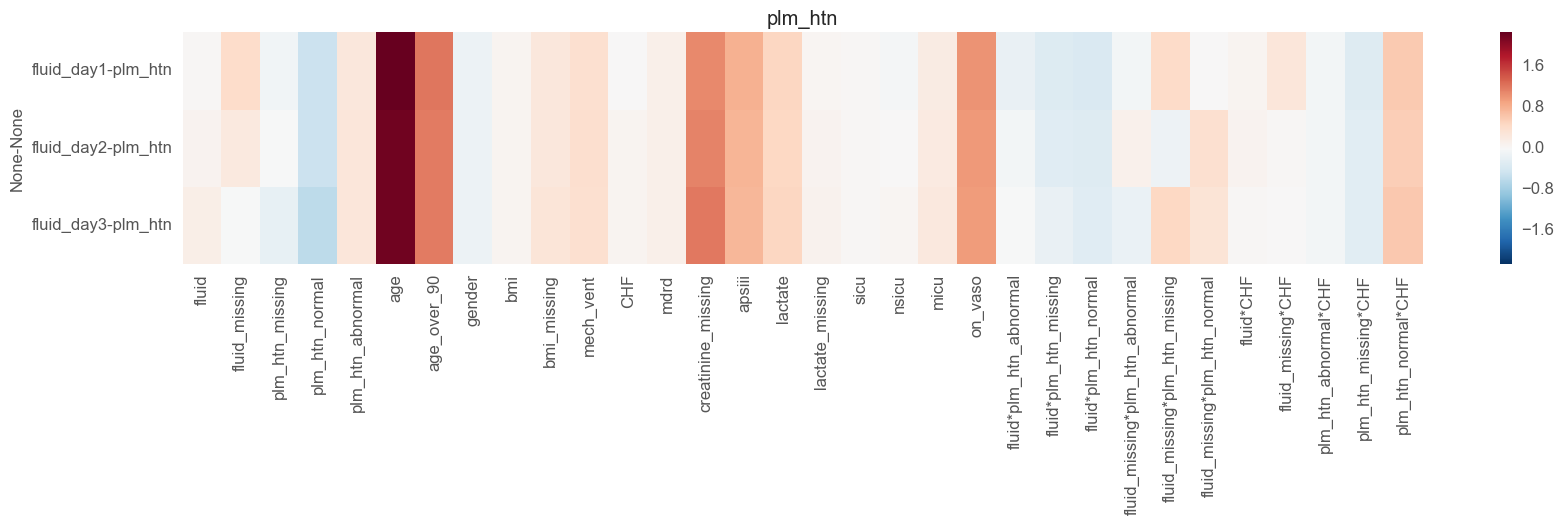

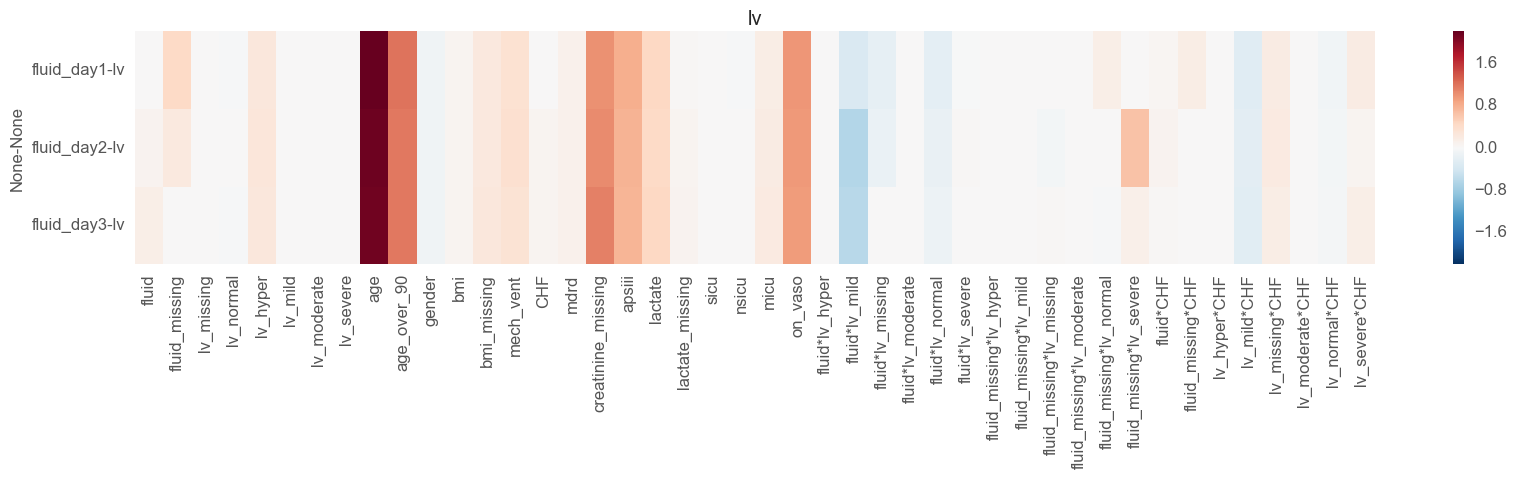

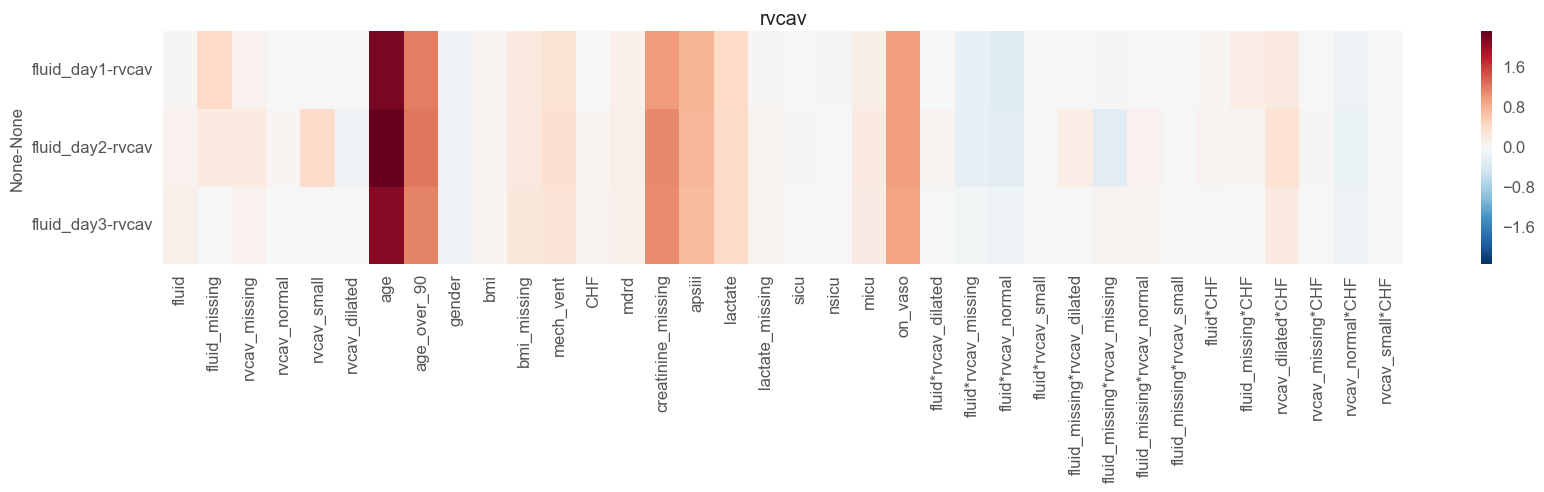

In [141]:
import copy

inspect = {}
cols = {}
it = copy.deepcopy(coefs)
for k, v in it.items():
    v.index = [c.replace(k[0], 'fluid') for c in v.index]
    inspect[k] = v
    cols[k[1]] = v.index
inspect = pd.DataFrame(inspect)

for echo_fs in echo_features.keys(): 

    to_plot = inspect.loc[cols[echo_fs],(slice(None), echo_fs)]
    plt.figure(figsize = (20,3))
    sns.heatmap(to_plot.transpose())
    plt.title(echo_fs)

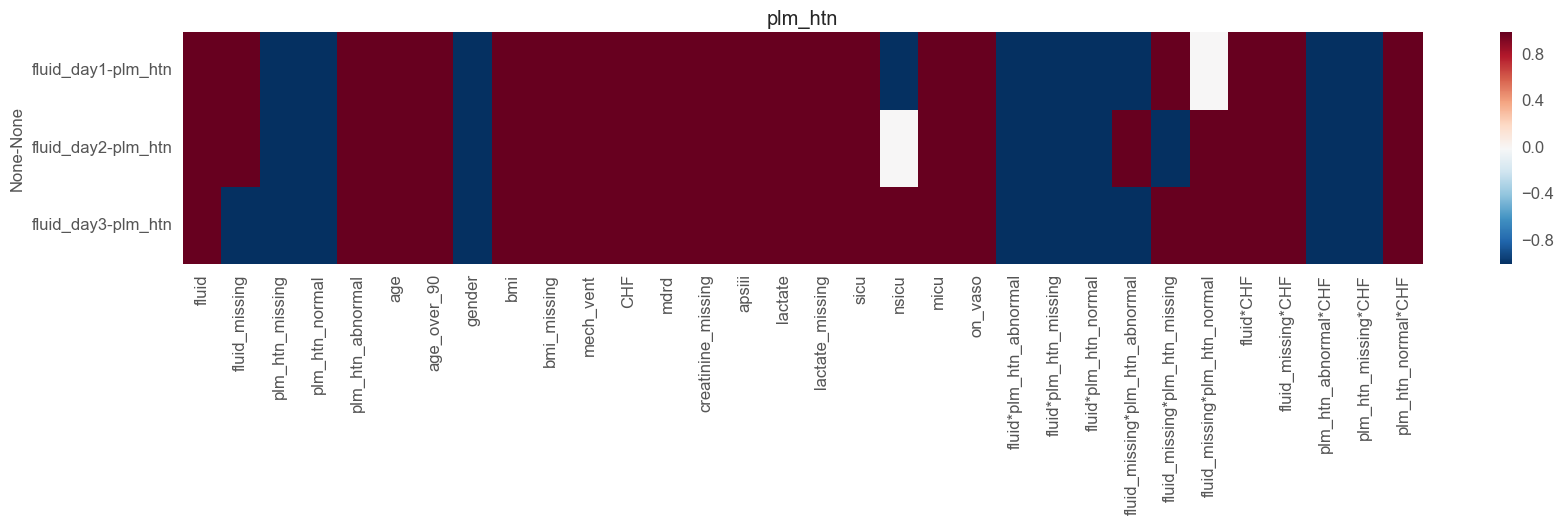

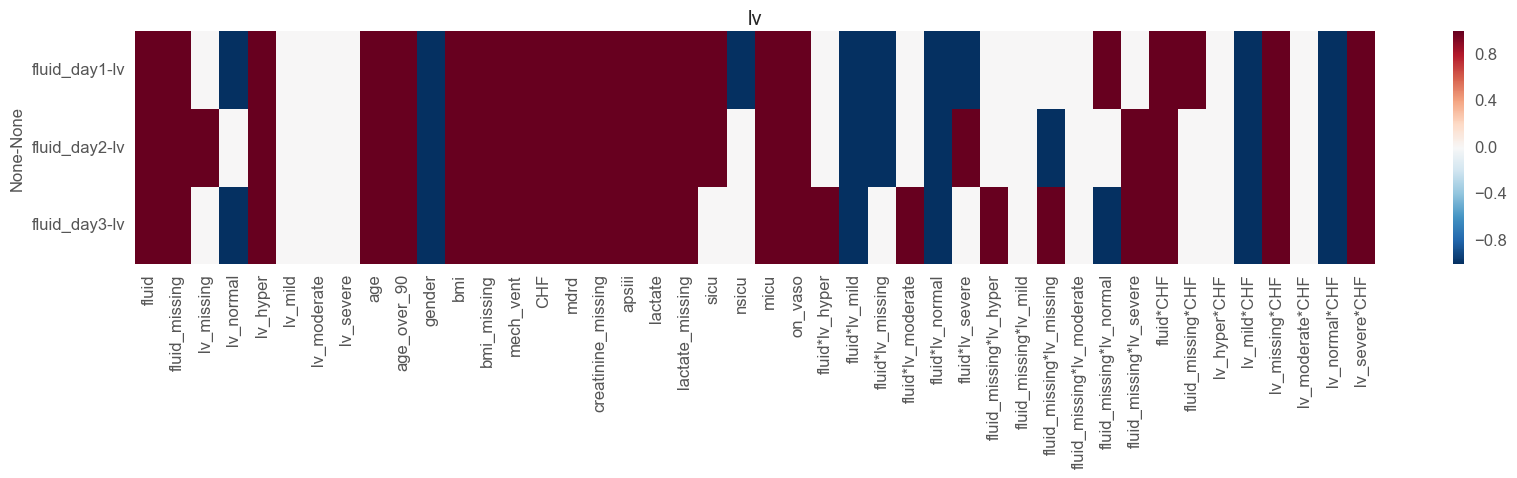

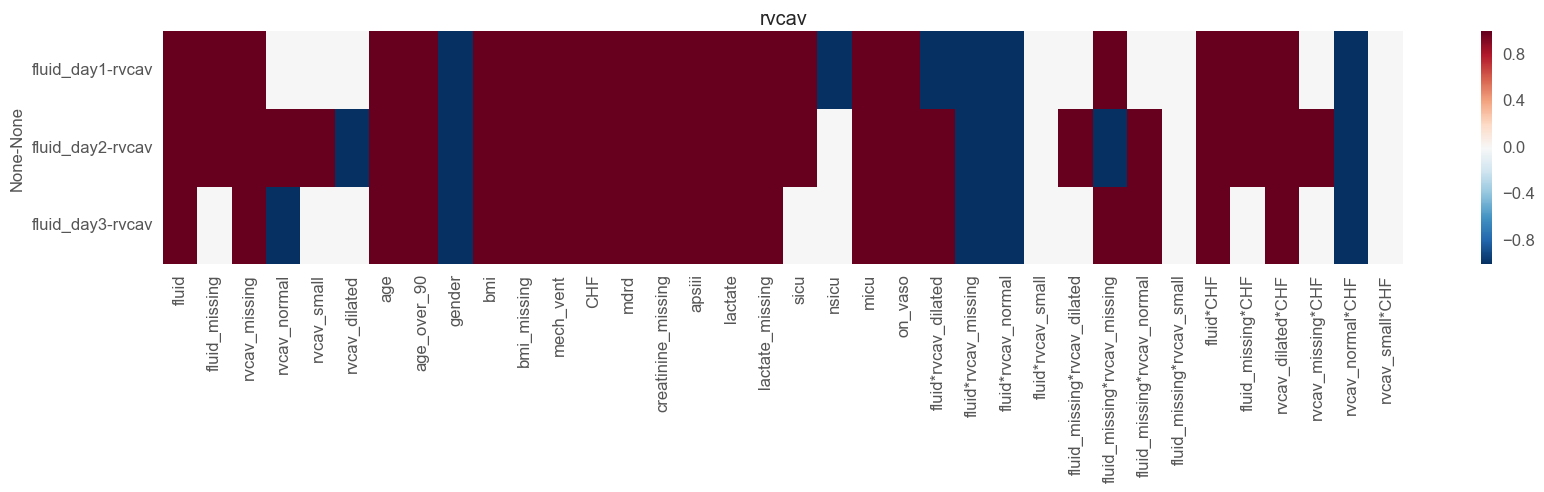

In [142]:
import copy

inspect = {}
cols = {}
it = copy.deepcopy(coefs)
for k, v in it.items():
    v.index = [c.replace(k[0], 'fluid') for c in v.index]
    inspect[k] = v
    cols[k[1]] = v.index
inspect = pd.DataFrame(inspect)

for echo_fs in echo_features.keys(): 

    to_plot = np.sign(inspect.loc[cols[echo_fs],(slice(None), echo_fs)])
    plt.figure(figsize = (20,3))
    sns.heatmap(to_plot.transpose())
    plt.title(echo_fs)